# BASE から，各国のコンテンツ数をとる
+ ドイツBielefeld Universityの BASE (Bielefeld Academic Search Engine)　https://www.base-search.net/ から、各国のリポジトリのコンテンツ数を取得（スクレイピング）してグラフ表示する。
+ コンテンツ数は、BASE が独自にハーベストした件数に依存している。
+ なので、ハーベスト対象リポジトリが、例えば日本は、NIIのIRDBとも、Open DOAR とも異なる。

In [1]:
# python
# BASE から，各国のコンテンツ数をとる
import requests
from bs4 import BeautifulSoup
import datetime
import locale
import re
import pandas as pd

df = pd.DataFrame()

country = ["jp","us","uk","ca","fr","de","it"]
# country = ["jp","us"]

time = datetime.datetime.now()
print(time)

for item in country:
   # r = requests.get('https://www.base-search.net/Search/Results?q=country:jp')
   r = requests.get('https://www.base-search.net/Search/Results?q=country:'+item) 
   data = BeautifulSoup(r.text, 'html.parser')
   # elems = data.find_all("form", id="ID_f_dctypenorm")
   # elems = data.find_all("select", id= "FS_f_dctypenorm")
   elems = data.find_all("option", value=re.compile("f_dctypenorm"))
   for e in elems:
      te = e.getText()
      te = te.strip('(')
      # splitでとじかっこで文字列を分割してlistに  
      se = te.split(') ')
      # countのカンマを削除
      se[0] = se[0].replace(',','')
      # print(se[0].type())
      se.insert(0, item)
      tmp_se = pd.Series( se )
      # count を文字列から数値に変換
      tmp_se[1] = int(tmp_se[1])
      df = df.append( tmp_se, ignore_index=True )
   
# カラム名をつける
df_new = df.rename(columns={0: 'country', 1:'count', 2:'kind'})
df_new

2020-05-23 15:54:04.963953


,country,count,kind
0,jp,1166543.0,Report
1,jp,714634.0,Article contribution
2,jp,477460.0,Unknown
3,jp,207587.0,Thesis
4,jp,175871.0,Conference object
...,...,...,...
166,it,126.0,Moving image/Video
167,it,36.0,Lecture
168,it,25.0,Software
169,it,10.0,Map


In [2]:
# 縦持ちのデータを横持ちにする
pivot_orders_df =\
df_new.pivot_table(values=['count'], index=['country'], columns=['kind'], aggfunc='sum', fill_value=0)

# 列のマルチインデックスの解除
pivot_orders_df.columns = pivot_orders_df.columns.droplevel(0)
pivot_orders_df

kind,Article contribution,Audio,Bachelor thesis,Book,Book part,Conference object,Course material,Dataset,Doctoral and postdoctoral thesis,Journal/Newspaper,...,Musical notation,Other non-article,Patent,Report,Review,Software,Still image,Text,Thesis,Unknown
country,,,,,,,,,,,,,,,,,,,,,
ca,369228,9421,35,19095,13104,18927,2006,1754,32436,134922,...,8845,2054,348,64135,30370,74,299937,419652,404505,356040
de,2059456,18255,18977,478759,390164,609638,33,728130,346103,56518,...,519,89351,2084,352095,67200,352,51886,3758714,26568,622345
fr,7391424,62751,0,783254,639263,1552098,401,19481,250820,15272,...,5519,9673,10659,584868,78355,707,983377,171622,103254,1595840
it,2488105,255,19460,159288,765634,924977,263799,200,70886,416,...,6,1688,13027,13265,4781,25,21842,103160,17452,717731
jp,714634,28,0,49697,1098,175871,13005,521,37082,34360,...,0,5,0,1166543,1240,37,1795,72872,207587,477460
uk,2508475,3352,1202,147553,247119,306514,7181,301238,88719,2396,...,24,127553,3531,111540,33101,3023,263103,443530,185911,1160685
us,3316058,147324,69245,440745,60905,167046,21761,174310,172944,1414273,...,133771,19619,22469,782357,19159,1082,5987953,28964131,582628,7512237


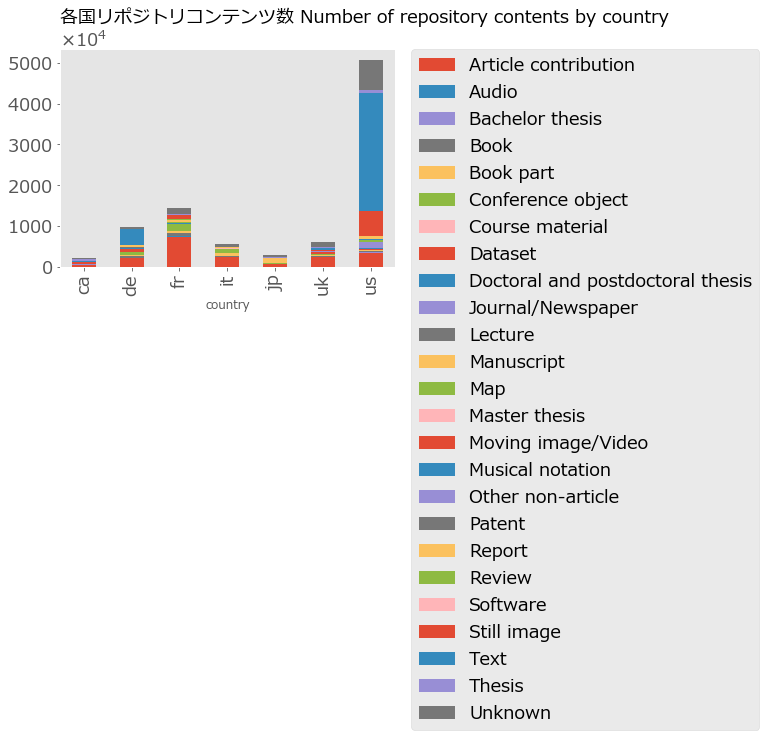

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick # べき乗表示のため

# チャートの設定
plt.style.use('ggplot') 
font = {'family' : 'meiryo'}
matplotlib.rc('font', **font)
#グラフ描画
ax1 = pivot_orders_df.plot.bar(stacked=True, fontsize=18)
# ax2 = pivot_orders_df.loc['us'].plot.bar(stacked=True, fontsize=18)
plt.title(u'各国リポジトリコンテンツ数 Number of repository contents by country\n', size=18,loc='left')
plt.grid(which='major')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
# Scientific notationの指数を10^{n}にする
ax1.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
ax1.yaxis.offsetText.set_fontsize(10)
ax1.ticklabel_format(style='sci',axis='y',scilimits=(4,4))
ax1.yaxis.offsetText.set_fontsize(18)

+ us（アメリカ）だけ突出しているので，アメリカを除いでグラフ化

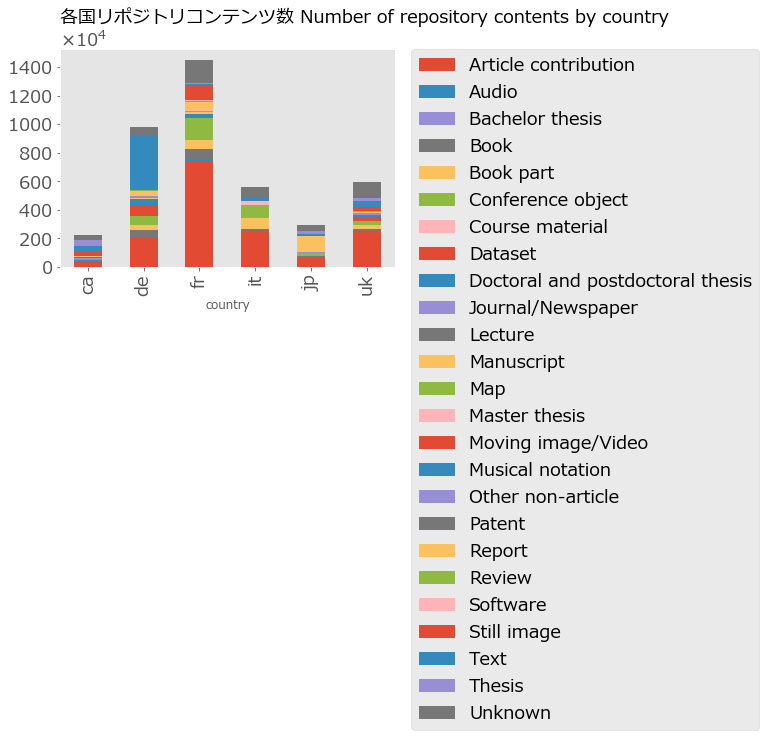

In [9]:
# us（アメリカ）だけ突出しているので，アメリカを除いでグラフ化
ax2 = pivot_orders_df[:6].plot.bar(stacked=True, fontsize=18)
plt.title(u'各国リポジトリコンテンツ数 Number of repository contents by country\n', size=18,loc='left')
plt.grid(which='major')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
# Scientific notationの指数を10^{n}にする
ax2.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
ax2.yaxis.offsetText.set_fontsize(10)
ax2.ticklabel_format(style='sci',axis='y',scilimits=(4,4))
ax2.yaxis.offsetText.set_fontsize(18)

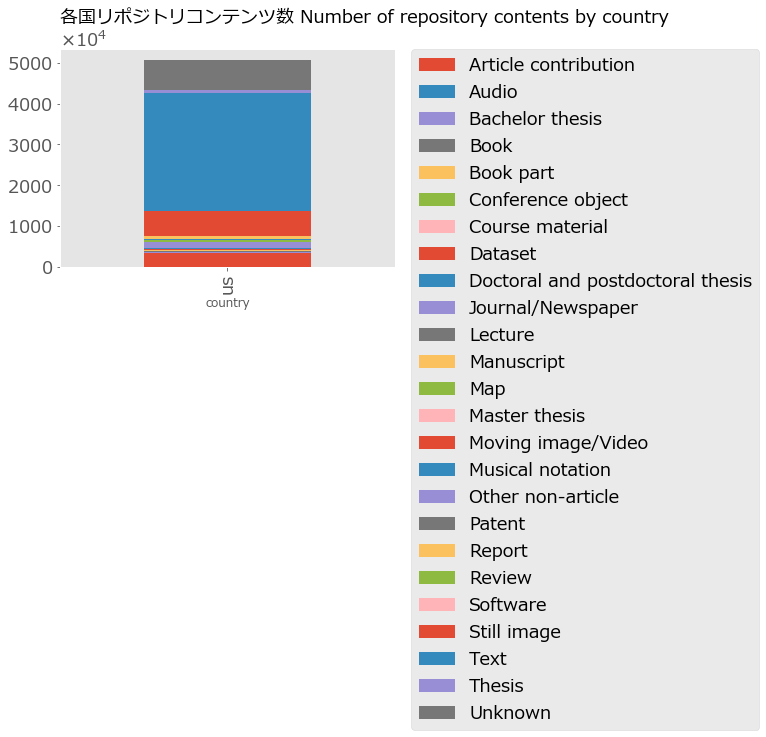

In [10]:
# アメリカのみグラフ
ax3 = pivot_orders_df[6:7].plot.bar(stacked=True, fontsize=18)
plt.title(u'各国リポジトリコンテンツ数 Number of repository contents by country\n', size=18,loc='left')
plt.grid(which='major')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
# Scientific notationの指数を10^{n}にする
ax3.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
ax3.yaxis.offsetText.set_fontsize(10)
ax3.ticklabel_format(style='sci',axis='y',scilimits=(4,4))
ax3.yaxis.offsetText.set_fontsize(18)

In [12]:
print(pivot_orders_df.index)
print(pivot_orders_df.columns)

Index(['ca', 'de', 'fr', 'it', 'jp', 'uk', 'us'], dtype='object', name='country')
Index(['Article contribution', 'Audio', 'Bachelor thesis', 'Book', 'Book part',
       'Conference object', 'Course material', 'Dataset',
       'Doctoral and postdoctoral thesis', 'Journal/Newspaper', 'Lecture',
       'Manuscript', 'Map', 'Master thesis', 'Moving image/Video',
       'Musical notation', 'Other non-article', 'Patent', 'Report', 'Review',
       'Software', 'Still image', 'Text', 'Thesis', 'Unknown'],
      dtype='object', name='kind')
